Data Preparation Notebook
======

Hi Merideth!  This is a step-by-step guide to the data-preparation process I underwent.  I try to do two somewhat contrary things here: I want to show you how I actually completed the steps (which is often less than the ideal way), while also illustrating what would be best to run in order to _replicate_ the work.

---

Imports: I suggest using ana/miniconda for the environment.  The command `conda create -n NAME -c conda-forge jupyter nb_conda dask pandas numpy scikit-learn fastparquet hdbscan geoviews` will be enough to replicate everything here.  It is then activated with `source activate NAME`.

In [13]:
# Data-manipulation imports
import dask
from dask import dataframe as dd
from dask.dataframe import to_parquet, read_parquet
from dask.diagnostics import ProgressBar
from sklearn.cluster import DBSCAN
from sklearn.neighbors import DistanceMetric
import pandas as pd
import numpy as np
import hdbscan
#import geoviews as gv

pbar = ProgressBar()
pbar.register()

# utilities
from multiprocessing import cpu_count
from datetime import datetime
from re import compile
from sklearn.externals.joblib import dump, load

### Cleaning/Paring [AS IT WAS DONE]

This next stretch of code is the process for turning the original download from `safecast.org` into the dataset to be used for clustering.  First, in the directory from which this notebook is launched, I assume you've run the following command(s):
```
wget https://api.safecast.org/system/measurements.tar.gz; tar -xvzf measurements.tar.gz
```
(This could take 10-15 minutes).  This should leave you with a 10+ GB `measurements-out.csv` file in the current directory.
At this stage for me, I was still operating on my laptop.  This would eventually become unwieldy and I would have to move to a cloud service.  For these steps, one would typically want a "compute-intensive" tier of machine.  The most economical version of this type of machine I saw was the 16-core compute-intensive resource from DigitalOcean at ~<span>\$</span>0.91/hr, but DigitalOcean did not have any of that type available at the specific hour I started, so I went to AWS (Amazon Web Services) instead.  While this next cell ran on my laptop, subsequent cells (until further notice) ran on a c4.8xlarge instance with 60 Gib of ram, 18 cpus of 2.9 Ghz (one thread each) at a rate of ~$1.49/hr.  I'm not sure it's worth imitating my resource use.  Even if all of these steps had executed in quick succession without hours of errors/aborted calls/memory failures, it likely was not maximally economical.  I used the Amazon Linux AMI, which I installed `git` and `miniconda` onto.  After which I created the environment with the command I recommended above.

---

In this block I read the csv in, providing dtype specifications for the `Surface` and `Radiation` columns.  They have mixed types so they need to be allowed to be read in as `object`.  I rename the `Time` column, drop the irrelevant (and mostly empty in some cases) list of columns in line 6.  I then write the repartitioned (with 24 partitions because of my 8-core machine) dataframe to parquet files (these are vastly superior, I can't recommend them enough).  The output is long (double click to reveal it) due to an error but shows that this process took ~10 minutes on a laptop.

In [9]:
# Making file more manageable by dropping undesired columns, renaming, repartitioning then saving in better file format.
# Only needed to be executed once; preserved for posterity.

mmnts = dd.read_csv('./measurements-out.csv', dtype={'Surface':'object', 'Radiation':'object'})
mmnts = mmnts.rename(columns={'Captured Time': 'Time'})
mmnts = mmnts.drop(['Device ID', 'MD5Sum', 'Height', 'Surface', 'Radiation', 'Uploaded Time', 'Loader ID'], axis=1)
ncores = cpu_count()
with ProgressBar():
    to_parquet( mmnts.repartition(npartitions=(3*ncores)), 
                '/mnt/c/users/eliw5/src/academic/Phys18Conf_1/', 
                engine='fastparquet', 
                compute=True,
    )

[                                        ] | 0% Completed | 11.1s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[##                                      ] | 5% Completed | 31.1s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[##                                      ] | 6% Completed | 44.8s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###                                     ] | 7% Completed | 48.6s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[####                                    ] | 10% Completed |  1min  5.0s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[####                                    ] | 12% Completed |  1min 12.3s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[####                                    ] | 12% Completed |  1min 13.9s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[######                                  ] | 16% Completed |  1min 38.9s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[#######                                 ] | 18% Completed |  1min 51.9s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[########                                ] | 22% Completed |  2min 13.5s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[##########                              ] | 25% Completed |  2min 27.8s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[##########                              ] | 26% Completed |  2min 35.1s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###########                             ] | 29% Completed |  2min 54.7s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###########                             ] | 29% Completed |  2min 57.1s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[#############                           ] | 32% Completed |  3min 16.5s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[#############                           ] | 33% Completed |  3min 19.7s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###############                         ] | 37% Completed |  3min 42.5s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[################                        ] | 41% Completed |  4min 11.3s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[##################                      ] | 45% Completed |  4min 34.3s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[##################                      ] | 47% Completed |  4min 43.4s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###################                     ] | 49% Completed |  5min  0.8s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[####################                    ] | 51% Completed |  5min  6.6s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[######################                  ] | 55% Completed |  5min 35.4s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[########################                ] | 62% Completed |  6min 18.5s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[#########################               ] | 63% Completed |  6min 33.4s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[############################            ] | 70% Completed |  7min  8.0s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[############################            ] | 70% Completed |  7min  9.2s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[############################            ] | 72% Completed |  7min 19.8s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[#############################           ] | 74% Completed |  7min 34.3s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###############################         ] | 78% Completed |  7min 57.4s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###############################         ] | 79% Completed |  8min  3.8s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[#################################       ] | 83% Completed |  8min 23.6s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[##################################      ] | 85% Completed |  8min 37.8s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###################################     ] | 87% Completed |  8min 48.5s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[###################################     ] | 88% Completed |  8min 58.1s

/home/shlomenu/anaconda3/envs/rad/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


[########################################] | 100% Completed | 10min  2.3s


Inelegantly, it took until I was over to the server to decide that I did not want to keep track of `Location Name`.  It seemed like a good idea, but it was sparse enough not to be worth the hassle in the end.  In this cell I drop that column and rewrite with more partitions (108 on my 18 core AWS instance).

In [5]:
mmnts = read_parquet('./data_files/first_trim/', engine='fastparquet')
mmnts = mmnts.drop(['Location Name'], axis='columns')
ncores = cpu_count()
mmnts = mmnts.repartition(npartitions=6*ncores)
with ProgressBar(), dask.config.set(scheduler='processes'):
    to_parquet( mmnts,
                './data_files/second_trim/',
                engine='fastparquet',
                compute=True
    )

[########################################] | 100% Completed |  1hr  3min  1.6s


Now lacking the sparse `Location Name` column, it was easy to `dropna` across all columns, since any sample lacking a `Time`, `Latitude`, `Longitude`, `Value`, or `Unit` was useless.  This step was surprisingly quick.

In [8]:
mmnts = read_parquet('./data_files/second_trim/', engine='fastparquet')
mmnts = mmnts.dropna()
with ProgressBar(), dask.config.set(scheduler='processes', optimize_graph=True):
    to_parquet( mmnts,
                './data_files/third_trim/',
                engine='fastparquet',
                compute=True
    )

[########################################] | 100% Completed | 49.6s


In this cell, I made the `Unit` column have the `category` dtype.  Dask dataframes have a built in `.categorize` method.  Initially, I resisted using this just as an animal spirit, and instead separated the `Unit` column, called `.astype('category').to_frame()`, and attempted to re-`merge` them.  This was a disastrous idea.  If it all possible, it is crucial to avoid `merge` on anything of size using Dask (and this dataset had 110 million entries when *I* downloaded it).  The best answer I saw in my troubleshooting (I didn't investigate the source) was that Dask inefficiently tries to build the entire merged dataframe in memory.  This would result in fully duplicating the whole 110 million entries, which could be significantly bigger in-memory than they appear as parquet files (where they total 5.6 GB).  Just this `merge` was capable of consuming more than 60 Gib (64 GB) of RAM.  Additionally, if Dask does not remember that, despite being separated, the dataframes have all the same partitions, it could cause a linear-time search for each sample across every partition of the merging dataframe.  I'm sure there are more detailed reasons for the failure.  The several, hour-long eventual failed steps have _not_ been kept here for posterity.

In [3]:
mmnts = read_parquet('./data_files/third_trim/', engine='fastparquet')
with ProgressBar(), dask.config.set(scheduler='processes', optimize_graph=True):
    to_parquet( mmnts.categorize(columns=['Unit'], index=False),
                '/home/ec2-user/Phys18Conf_1/data_files/fourth_trim/',
                engine='fastparquet',
                compute=True,
    )

[########################################] | 100% Completed | 20.3s
[########################################] | 100% Completed | 18.5s


This cell contains the most substantive transformation so far: changing the Python object time-stamp strings into numbers of seconds since 2011 (a month or two before the first datum).  This will later be necessary so that DBSCAN can do its temporal clustering with a readable value.  Once again motivated by avoiding `dask.DataFrame.merge` at all costs, we find a way to, in parallel and without changing/splitting the dataframe, apply the desired transformation only to the `Time` column entries.  We do this by mapping to each partition (`.map_partitions`) a `lambda`, that calls `pandas.DataFrame.apply`, _column-wise_ with the function `filt`.  `filt` checks if the column has `dtype == 'object` (as only the `Time` column will).  If so, it calls `pandas.Series.apply` on the _column_ (always the `Time` column in practice) with `tconv`, which reads the string into a Python `datetime` object; takes its difference from 2011 as a `time_delta`; then converts that to seconds as an numpy `int64`.  There are three levels of `apply` going on here!

In [9]:
start_dt = datetime.strptime('2011-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
microseconds = compile('\.\d*')

def filt(col):
    if col.dtype != 'object':
        return col
    else:
        return col.apply(tconv)
    
def tconv(s):
    dt = datetime.strptime(microseconds.sub('', str(s)), '%Y-%m-%d %H:%M:%S')
    delta = dt - start_dt
    result = np.array(delta.total_seconds())
    return result.astype(np.int64)

mmnts = read_parquet('./data_files/fourth_trim/', engine='fastparquet')
_meta = {'Time': 'int64', 'Latitude': 'float64', 'Longitude': 'float64', 'Value': 'float64', 'Unit': 'category'}
mmnts = mmnts.map_partitions(lambda df: df.apply(filt, axis=0), meta=_meta)
with ProgressBar(), dask.config.set(scheduler='processes', optimize_graph=True):
    to_parquet( mmnts,
               '/home/ec2-user/Phys18Conf_1/data_files/fifth_trim',
               engine='fastparquet',
               compute=True
    )

[########################################] | 100% Completed |  1min 56.6s


For comparison, the dataframe has just about 110 million rows before we drop the inappropriate units.  After, it would have about 102 million.

In [13]:
len(mmnts)

109799687

Here we see the distribution of values across the categories of `Unit`.  The vast majority are CPMs.  We would maintain almost all the data by only taking the rows of category `cpm`.  A number of units are totally uninterpretable/unusable.  `status` is not any kind of unit as far as I can tell. (Perhaps it is a default that people forget to change when submitting their observations?).  Perhaps there is some way to measure radiation as a temperature, but I couldn't find any evidence of `celcius` as a unit of radiation.  `1`, `0`, `DeviceType1`, `DeviceType2` are not units at all.  From brief investigation, it appears that `PM1`, `PM2.5`, `PM10`, `pm2.5` are a type of air quality measure.  This is probably because SafeCast is trying to break into other kinds of environmental monitoring, including air quality.  This also appears to be the source of `NOXppm` and `HUMD%`.  `RSSI` is a measure of radio signal strength.  `TEMPC`, perhaps another temperature measurement.  The only reputable alternative measurement present is the Sievert.  I looked into converting the sievert measurements to CPMs, but it appears that _how_ to do this conversion depends on what atomic substance the Geiger counter was calibrated with: CPMs translate differently to Sieverts calibrated with Cobalt isotope than with Caesium isotope.  This information was not present even in the full table, so this ruled out the conversion.  Unfortunately, the largest chunks left on the table were not the Sieverts, but the unsalvageable `status` and the `celcius`.  

In [20]:
mmnts = read_parquet('/home/ec2-user/Phys18Conf_1/data_files/fifth_trim/', engine='fastparquet')
with ProgressBar():
    out = mmnts['Unit'].value_counts().compute(scheduler='processes', optimize_graph=True)

[########################################] | 100% Completed |  0.7s


In [21]:
out

cpm             102927743
status            3765116
celcius           2775932
usv                279888
microsievert        30096
 cpm                10043
1                    8892
DeviceType2          1363
CPM                   289
Cpm                    55
DeviceType1            45
usv/hr                 43
uSv/h                  43
PM1                    28
HUMD%                  20
PM2.5                  17
0                      15
uSv                    14
PM10                   13
NOXppm                 12
TEMPC                  11
pm2.5                   4
uSv/hr                  3
RSSI                    2
Name: Unit, dtype: int64

Nonetheless, we could retain the ~11,000 measurements separated only by the alternate spellings of CPM.  Now that all units were CPM, we could discard the `Unit` column entirely.  `out2[:-2]` merely gets rid of two rows with bad time stamps (instead of 2011 they read 201).  This wasn't done earlier because `dask.DataFrame.drop` does not support dropping rows.  

In [23]:
with ProgressBar():
    out2 = mmnts[mmnts['Unit'].isin(['cpm', ' cpm', 'CPM', 'Cpm'])].compute(scheduler='processes', optimize_graph=True)

[########################################] | 100% Completed | 36.4s


In [43]:
out2

,Time,Latitude,Longitude,Value
0,286909200,37.507552,139.941170,72.0
1,286887600,37.507250,139.940000,55.0
2,286887600,37.505445,0.016667,68.0
3,286686000,34.066487,-118.895217,50.0
4,286678800,37.673233,140.066667,48.0
5,286678800,37.674782,140.079895,52.0
6,285015600,37.517902,139.925478,59.0
7,285015600,37.754973,140.687660,384.0
8,285015600,37.526595,139.931667,59.0
9,285015600,37.737157,140.726832,441.0


In [42]:
out2.drop('Unit', axis=1, inplace=True)
out3 = dd.from_pandas(out2[:-2], npartitions=108)
with ProgressBar(), dask.config.set(scheduler='processes', optimize_graph=True):
    to_parquet( out3,
                '/home/ec2-user/Phys18Conf_1/data_files/sixth_trim/',
                engine='fastparquet',
                compute=True,
    )

[########################################] | 100% Completed | 16.4s


### Cleaning/Paring [AS IT SHOULD BE DONE]

---

This cell, as long as the initial csv was read validly from a file system, and written back as parquet files validly to a file system, would complete all the above transformations in a single step. 

Using the `usecols` keyword argument, only the five columns of interest are read in from the original csv.  Renaming, repartitioning, dropping NaNs, categorizing, and numerifying of the `Time` column are all done before calling `.compute`.  The categories which are typographical variations on CPM are automatically identified and those rows agglomerated before `Unit` is dropped.   `Time` is numerified after these steps so that observations which will not be used are never converted.  I also realized that you can simply reassign a column within a dataframe without a merge--oops!  We compute the dataframe before writing it back because it _seems_ to be the only way to drop the last two rows with messed-up time stamps.  If it was possible to `.concat` a dask dataframe with a pandas dataframe then I might try to compute only the last partition to drop the rows.  But since there is not, it seems there is no getting around calling `.compute` on the entire dataframe.    

In [ ]:
mmnts = dd.read_csv('measurements-out.csv', usecols=['Captured Time', 'Latitude', 'Longitude', 'Value', 'Unit'])
mmnts = mmnts.rename(columns={'Captured Time': 'Time'})
mmnts = mmnts.repartition(npartitions=(6*cpu_count()))
mmnts = mmnts.dropna()
with dask.config.set(scheduler='processes'):
    mmnts = mmnts.categorize(columns=['Unit'], index=False)
cpms = []
for category in mmnts['Unit'].cat.categories:
    if category.lower().strip() == 'cpm':
        cpms.append(category)
mmnts = mmnts[mmnts['Unit'].isin(cpms)]

start_dt = datetime.strptime('2011-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
microseconds = compile('\.\d*')

def tconv(s):
    dt = datetime.strptime(microseconds.sub('', str(s)), '%Y-%m-%d %H:%M:%S')
    delta = dt - start_dt
    result = np.array(delta.total_seconds())
    return result.astype(np.int64)

mmnts['Time'] = mmnts['Time'].apply(tconv, axis=1, meta=('Time', 'int64'))
mmnts_out = mmnts.compute(scheduler='processes', optimize_graph=True)
mmnts = dd.from_pandas(mmnts_out[:-2], npartitions=(6*cpu_count()))
with dask.config.set(scheduler='processes', optimize_graph=True):
    to_parquet( mmnts,
                '/path/to/your/storage/location/',
                engine='fastparquet',
                compression='snappy'
                compute=True,
    )

### Clustering [AS IT WAS DONE]

---

My first step here was to invest significant time in attempting to visualize all 100 million points.  This was a costly and unsuccessful detour for several reasons: (1) the only library which could handle this number of points could not handle non-Cartesian coordinate systems; (2) almost all of the libraries in the visualization space except the oldest (and therefore least high-performing) are quite poorly documented.  `datashader`, `geoviews`, and `holoviews` documentation is mostly jupyter notebooks demonstrating very particular use cases.  They were not at all up to the task of answering finicky questions about cross-compatibility.  If there truly is a way to combine the performance of datashader with the coordinate systems of geoviews, it was not addressed substantively in any documentation I could find.  I came across a ticket in which an author claims that datashader can respect non-Cartesian coordinate systems, but I could not find any instance of using it in which it is clear how one either declares the coordinate reference system, or feeds in any object which records it.

Instead, by using the somewhat primitive heat map at `safecast.org/tilemap/`, this image: 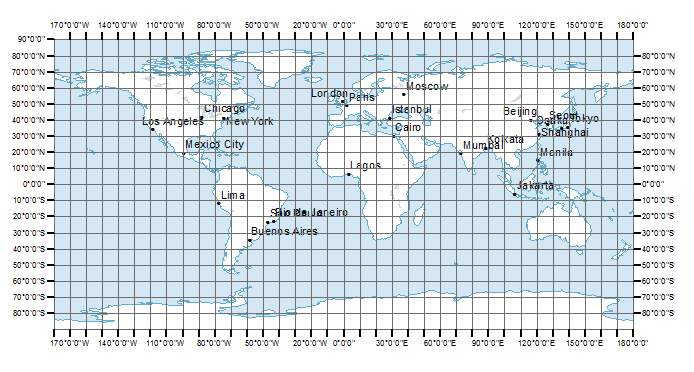 and Google Earth, I was able to roughly "bin" the observations into 

In [8]:
#mmnts         = read_parquet('/home/ec2-user/Phys18Conf_1/data_files/sixth_trim', engine='fastparquet')
rem           = mmnts.compute(scheduler='processes', optimize_graph=True)
rem.rename(columns={'Time':'time', 'Latitude':'lat', 'Longitude':'lon', 'Value':'val'}, inplace=True)

north_america = rem[((rem['lon'] < -40) | (rem['lon'] > 160)) 
                      & 
                    (rem['lat'] > 15)]

rem           = rem[~(((rem['lon'] < -40) | (rem['lon'] > 160)) 
                      & 
                    (rem['lat'] > 15))]

south_america = rem[((-90 < rem['lon']) & (rem['lon'] < -25)) 
                      & 
                    ((-60 < rem['lat']) & (rem['lat'] < 15))]

rem           = rem[~(((-90 < rem['lon']) & (rem['lon'] < -25)) 
                      & 
                    ((-60 < rem['lat']) & (rem['lat'] < 15)))]

# dropping fukushima meltdown
before = len(rem)
rem           = rem[~(((36.58 < rem['lat']) & (rem['lat'] < 38.083)) 
                      & 
                    ((138.75 < rem['lon']) & (rem['lon'] < 141.25)))]
after = len(rem)
discarded = before - after

japan_korea   = rem[((28.876 < rem['lat']) & (rem['lat'] < 47.46)) 
                      & 
                    ((117.675 < rem['lon']) & (rem['lon'] < 160))]

rem           = rem[~(((28.876 < rem['lat']) & (rem['lat'] < 47.46)) 
                      & 
                    ((117.675 < rem['lon']) & (rem['lon'] < 160)))]

australia     = rem[((-50 < rem['lat']) & (rem['lat'] < -10)) 
                      & 
                    ((105 < rem['lon']) & (rem['lon'] < 160))]

rem           = rem[~(((-50 < rem['lat']) & (rem['lat'] < -10)) 
                      & 
                    ((105 < rem['lon']) & (rem['lon'] < 160)))]

w_europe      = rem[((18.5 < rem['lat']) & (rem['lat'] < 72.5)) 
                      & 
                    ((-30 < rem['lon']) & (rem['lon'] < 44))]

rem           = rem[~(((18.5 < rem['lat']) & (rem['lat'] < 72.5)) 
                      & 
                    ((-30 < rem['lon']) & (rem['lon'] < 44)))]

africa        = rem[((-40 < rem['lat']) & (rem['lat'] < 11)) 
                      & 
                    ((-25 < rem['lon']) & (rem['lon'] < 60))]

rem           = rem[~(((-40 < rem['lat']) & (rem['lat'] < 11)) 
                      & 
                    ((-25 < rem['lon']) & (rem['lon'] < 60)))]

elsewhere     = rem

[########################################] | 100% Completed | 23.2s


In [10]:
sum = len(north_america)+len(south_america)+len(japan_korea)+len(australia)+len(w_europe)+len(africa)+len(elsewhere)+discarded
print("Point Distribution among Regions:\n")
print("North America:                   " + str(len(north_america)))
print("South America:                   " + str(len(south_america)))
print("Japan and South Korea:           " + str(len(japan_korea)))
print("Australia:                       " + str(len(australia)))
print("Western Europe:                  " + str(len(w_europe)))
print("(Most of) Africa:                " + str(len(africa)))
print("Proximate to Fukushima Meltdown: " + str(discarded))
print("Everywhere else:                 " + str(len(elsewhere)))
print("Total:                           " + str(sum) + "\n")
print(\
'''
Subtracting the points proximate to the Fukushima meltdown, we are left with 
 
                             ''' + str(sum - discarded))

Point Distribution among Regions:

North America:                   20020113
South America:                   289636
Japan and South Korea:           31819071
Australia:                       1396507
Western Europe:                  24888188
(Most of) Africa:                832130
Proximate to Fukushima Meltdown: 18747474
Everywhere else:                 4945011
Total:                           102938130


Subtracting the points proximate to the Fukushima meltdown, we are left with 
 
                             84190656


In [14]:
with dask.config.set(scheduler='processes', optimize_graph=True):
    to_parquet( dd.from_pandas(north_america, npartitions=18), 
                '/home/ec2-user/Phys18Conf_1/data_files/split/north-america/',
                compute=True,
              )
    south_america.to_parquet('/home/ec2-user/Phys18Conf_1/data_files/split/south-america/south-america.parquet',
                             engine='fastparquet',
                             compression=None)
    to_parquet( dd.from_pandas(japan_korea, npartitions=36), 
                '/home/ec2-user/Phys18Conf_1/data_files/split/japan-korea/',
                compute=True,
              )
    to_parquet( dd.from_pandas(australia, npartitions=2),
                '/home/ec2-user/Phys18Conf_1/data_files/split/australia/',
                compute=True,
              )
    to_parquet( dd.from_pandas(w_europe, npartitions=27),
                '/home/ec2-user/Phys18Conf_1/data_files/split/western-europe/',
                compute=True
              )
    africa.to_parquet('/home/ec2-user/Phys18Conf_1/data_files/split/africa/africa.parquet',
                      engine='fastparquet',
                      compression=None)
    to_parquet( dd.from_pandas(elsewhere, npartitions=6),
                '/home/ec2-user/Phys18Conf_1/data_files/split/elsewhere/',
                compute=True,
              )

[########################################] | 100% Completed |  4.5s
[########################################] | 100% Completed |  6.6s
[########################################] | 100% Completed |  0.7s
[########################################] | 100% Completed |  5.1s
[########################################] | 100% Completed |  1.4s


In [10]:
epsilon = 8.04672/6371.
mspl = 15

In [12]:
south_america = pd.read_parquet('/home/ec2-user/Phys18Conf_1/data_files/split/south-america/south-america.parquet', engine='fastparquet')
south_america_clusterer = DBSCAN(eps=epsilon, min_samples=mspl, metric='haversine', algorithm='ball_tree', n_jobs=-1)
south_america_clusterer.fit(np.radians(south_america[['lat', 'lon']].values))
dump(south_america_clusterer, '/home/ec2-user/Phys18Conf_1/data_files/pickles/south-america-clustering-1.pkl')

['/home/ec2-user/Phys18Conf_1/data_files/pickles/south-america-clustering-1.pkl']

In [14]:
%%time
south_america_hdbscan_trial = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=20, metric='haversine', core_dist_n_jobs=-1)
south_america_hdbscan_trial.fit(np.radians(south_america[['lat', 'lon']].values))
dump(south_america_hdbscan_trial, '/home/ec2-user/Phys18Conf_1/data_files/pickles/south-america-hdbscan-test-2.pkl')

/home/ec2-user/miniconda3/envs/rad/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/ec2-user/miniconda3/envs/rad/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/ec2-user/miniconda3/envs/rad/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)
/home/ec2-user/miniconda3/envs/rad/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py:268: DeprecationWarning: check_pickle is deprecated in joblib 0.12 and will be removed in 0.13
  ' removed in 0.13', DeprecationWarning)


CPU times: user 2min 15s, sys: 0 ns, total: 2min 15s
Wall time: 2min 5s


In [25]:
unique, counts = np.unique(south_america_clusterer.labels_, return_counts=True)
dict(zip(unique, counts))

{-1: 12607,
 0: 2782,
 1: 3910,
 2: 3220,
 3: 3994,
 4: 35801,
 5: 113,
 6: 85,
 7: 156,
 8: 65,
 9: 113,
 10: 108,
 11: 22,
 12: 13136,
 13: 370,
 14: 49,
 15: 27,
 16: 24,
 17: 65,
 18: 60,
 19: 18,
 20: 60,
 21: 63,
 22: 24310,
 23: 10685,
 24: 17315,
 25: 13761,
 26: 1491,
 27: 7533,
 28: 7501,
 29: 16379,
 30: 2694,
 31: 43,
 32: 87,
 33: 15,
 34: 21583,
 35: 8284,
 36: 3643,
 37: 19169,
 38: 820,
 39: 23899,
 40: 5869,
 41: 180,
 42: 146,
 43: 25,
 44: 18,
 45: 22,
 46: 21,
 47: 26,
 48: 11,
 49: 27,
 50: 28,
 51: 26,
 52: 25,
 53: 27,
 54: 18,
 55: 27,
 56: 28,
 57: 28,
 58: 18,
 59: 28,
 60: 16,
 61: 28,
 62: 19,
 63: 24,
 64: 15,
 65: 16,
 66: 46,
 67: 27,
 68: 18,
 69: 27,
 70: 21,
 71: 26,
 72: 27,
 73: 28,
 74: 29,
 75: 27,
 76: 52,
 77: 26,
 78: 18,
 79: 28,
 80: 28,
 81: 6205,
 82: 7486,
 83: 848,
 84: 10837,
 85: 1056}

In [27]:
print('Mean:   ' + str(np.mean(counts)))
print('Median: ' + str(np.median(counts)))

Mean:   3329.1494252873563
Median: 49.0


In [28]:
unique, counts = np.unique(south_america_hdbscan_trial.labels_, return_counts=True)
dict(zip(unique, counts))

{-1: 56517,
 0: 1491,
 1: 2120,
 2: 271,
 3: 1876,
 4: 245,
 5: 125,
 6: 411,
 7: 132,
 8: 397,
 9: 236,
 10: 563,
 11: 151,
 12: 307,
 13: 289,
 14: 698,
 15: 140,
 16: 1196,
 17: 397,
 18: 855,
 19: 103,
 20: 557,
 21: 267,
 22: 256,
 23: 264,
 24: 371,
 25: 204,
 26: 200,
 27: 217,
 28: 727,
 29: 375,
 30: 161,
 31: 293,
 32: 112,
 33: 331,
 34: 212,
 35: 193,
 36: 111,
 37: 105,
 38: 274,
 39: 109,
 40: 208,
 41: 406,
 42: 253,
 43: 256,
 44: 362,
 45: 331,
 46: 405,
 47: 277,
 48: 229,
 49: 162,
 50: 175,
 51: 126,
 52: 224,
 53: 369,
 54: 417,
 55: 120,
 56: 374,
 57: 185,
 58: 168,
 59: 254,
 60: 163,
 61: 907,
 62: 103,
 63: 118,
 64: 247,
 65: 168,
 66: 338,
 67: 345,
 68: 187,
 69: 186,
 70: 295,
 71: 152,
 72: 258,
 73: 285,
 74: 199,
 75: 247,
 76: 187,
 77: 123,
 78: 139,
 79: 227,
 80: 469,
 81: 148,
 82: 133,
 83: 119,
 84: 154,
 85: 442,
 86: 208,
 87: 109,
 88: 112,
 89: 105,
 90: 264,
 91: 288,
 92: 206,
 93: 149,
 94: 305,
 95: 312,
 96: 131,
 97: 129,
 98: 113,
 99:

In [29]:
print('Mean:   ' + str(np.mean(counts)))
print('Median: ' + str(np.median(counts)))

Mean:   360.69240348692404
Median: 223.0


In [46]:
unique, counts = np.unique(south_america_hdbscan_trial.probabilities_, return_counts=True)
for key, val in dict(zip(unique, counts)).items():
    print(str(key) + ': ' + str(val))

0.0: 56868
0.00012674657550220935: 1
0.0001272287722463498: 1
0.00012736811090175294: 1
0.00012771741585407653: 21
0.00012791738783862126: 1
0.0001284962747812042: 1
0.00012877909274252238: 2
0.0001290394381780945: 1
0.00012919020610502438: 1
0.0001296198494002924: 1
0.0001297305231954894: 1
0.00013110486107365256: 1
0.00013127462524565315: 1
0.0001326989418836549: 1
0.00013322000128208246: 1
0.00013389918273614575: 1
0.00013391107672818269: 1
0.0001340347558110272: 1
0.0001346430312383263: 1
0.0001437365552057703: 1
0.00014595225106699258: 1
0.00015426647056610202: 1
0.00015788680372227877: 2
0.0001580075338805283: 12
0.00015804035124873759: 1
0.0001580536399884865: 1
0.00016005615000607947: 1
0.00016045500320573306: 1
0.00016263495989935243: 1
0.00016300490855183388: 1
0.00016335044257995265: 1
0.0001637289426396629: 1
0.00016883294123208405: 1
0.00016912566632569946: 1
0.00016942754447179378: 1
0.00016947913673787834: 1
0.00016957079512037795: 1
0.00016968332084381336: 1
0.000169722

0.0017994133672184663: 1
0.001802135223266174: 1
0.0018021560758563326: 1
0.0018033759929349605: 1
0.0018037731277491635: 1
0.001807932040356704: 1
0.0018084482567213415: 1
0.0018094177594897127: 1
0.0018094499671600646: 1
0.0018111091203226023: 1
0.0018113782840729988: 1
0.0018115520067202968: 1
0.0018120511576061062: 1
0.0018161792187734106: 1
0.0018178034496535345: 1
0.0018182607522956265: 1
0.0018186082638374285: 1
0.0018192091473057388: 1
0.0018227763770432101: 1
0.001824476917477969: 1
0.0018247250986065794: 1
0.001826172169322396: 1
0.0018266132618663263: 1
0.0018269040778656359: 1
0.0018277140973524425: 1
0.0018297993582150195: 1
0.0018298873252249406: 1
0.0018301506243140829: 1
0.0018310885280568424: 1
0.0018331195210815234: 1
0.0018337366457028513: 1
0.001835692166400117: 1
0.0018359308302540649: 1
0.0018378490788580428: 1
0.0018420977141087671: 1
0.0018421739941530554: 1
0.001843162542688103: 1
0.001843543307242271: 1
0.0018451261471400947: 1
0.0018456019190209426: 1
0.00184

0.007640432112882227: 2
0.0076457759242270825: 1
0.007647066120429451: 1
0.00765025232818727: 1
0.00765205982287148: 1
0.007656928331500543: 1
0.007660175003046999: 1
0.007670061493662017: 1
0.007672190519720588: 1
0.0076736361733579445: 1
0.00767698189360383: 1
0.007680618596582125: 1
0.007682782316275566: 1
0.007684003433015104: 1
0.007693243716187198: 1
0.0076973645956496485: 1
0.007699195211262079: 46
0.007710076805341639: 1
0.007712296774263143: 1
0.007715244278294535: 1
0.007722954044379642: 1
0.007725535740717564: 1
0.0077323656771909255: 1
0.0077375066874091035: 49
0.0077377409276154245: 1
0.00773791611616152: 1
0.007743854181242387: 1
0.007748530460320957: 1
0.007748673095305758: 1
0.007749197460140744: 1
0.007752116826589581: 1
0.007758803164020673: 1
0.007760111606243667: 1
0.007761694424641338: 1
0.007773934331977741: 1
0.007775167466687562: 1
0.007777795437878365: 1
0.007784775608931314: 1
0.007788482021344715: 1
0.007792989484691558: 1
0.007797919638151779: 1
0.0077997315

0.04088700136721776: 1
0.040951856580687604: 1
0.040962381808776815: 1
0.04096706062743092: 1
0.04103969956152602: 1
0.04114128157984401: 1
0.04114192190072752: 1
0.04116322934579148: 1
0.04118565917922743: 1
0.04123426568224338: 13
0.041246140711647346: 1
0.04127663617694668: 1
0.0413234497614801: 1
0.041351905154843: 1
0.04135720523707412: 1
0.04136891689536018: 1
0.04142061813279071: 1
0.041483726737559005: 1
0.04149746232186953: 1
0.04151017918553858: 1
0.041530343566803934: 1
0.04153070491976601: 1
0.04156072385412639: 1
0.04157605467202618: 1
0.04157968892481937: 1
0.04161241358973287: 1
0.041660670800164605: 1
0.04166165871823835: 1
0.041666945649160986: 1
0.0417474160199866: 1
0.04175940425893493: 1
0.04176072266798223: 1
0.041761805804443275: 1
0.04176619145262423: 1
0.04177041645196863: 1
0.041776565845367944: 1
0.04178045317827502: 1
0.04178103344254003: 1
0.04180937055335169: 1
0.04183604273864412: 1
0.04187152774288745: 1
0.04188949475640104: 1
0.04192603524669624: 1
0.041

0.11819834124516068: 1
0.11836582435729327: 1
0.11838063384702621: 1
0.11845364745197264: 1
0.11855936705160879: 1
0.11855941855971956: 2
0.11862500030402386: 1
0.11865045849058362: 1
0.11866905111977467: 1
0.11871079893923235: 2
0.11871782819113728: 2
0.11877197400011918: 1
0.11877403521424656: 1
0.11885007528850311: 1
0.11887871187730639: 1
0.11890903455018483: 1
0.11903479933355167: 1
0.1190656202764321: 1
0.11912983698347299: 1
0.11916804622331562: 1
0.11918320259233073: 1
0.1192295131096689: 1
0.11926309285246234: 2
0.11934166731289936: 1
0.11934806871105738: 1
0.119393127776245: 1
0.11940989488107298: 1
0.11945234736879755: 1
0.11948043496690074: 1
0.11948633299475934: 2
0.11949964814652457: 1
0.1195638887324195: 1
0.11956427249149544: 1
0.11957276943845067: 5
0.11959392567868664: 1
0.11960274056887399: 1
0.1197005083722438: 1
0.11974334155527355: 1
0.11979651665735555: 1
0.11984152844475175: 1
0.11986934320218756: 1
0.12001230020056933: 3
0.12014125384873281: 1
0.120156374780982

0.20825226664685353: 1
0.2082961592762754: 1
0.20835300049369151: 1
0.20840010147023647: 1
0.20841933023989373: 1
0.20842974509173479: 1
0.20853527728502036: 1
0.20857932846519053: 1
0.20858109349985873: 1
0.20875389360182597: 2
0.20884419294868856: 1
0.20884914659272744: 1
0.20890160379043365: 1
0.20891389877545985: 1
0.20894366070712572: 1
0.20895686154777962: 1
0.2090044971728576: 1
0.20901069564933045: 1
0.20901100418088328: 1
0.2090485382897647: 1
0.20908045580797072: 1
0.209120591381815: 1
0.20912063803183742: 1
0.20914117559982606: 1
0.20914822780110742: 1
0.2091708928652413: 1
0.2092170172427222: 1
0.20924207309962356: 1
0.20924207887722668: 1
0.2092421681930415: 1
0.20924221666612572: 1
0.20929525546874544: 1
0.20929997985087334: 1
0.20931851972760723: 1
0.20933427668042753: 1
0.20941138890109007: 1
0.20941139247512958: 1
0.20941150302518266: 1
0.2094648787298641: 1
0.20948397151266407: 1
0.20955368570776137: 1
0.20958879700106375: 1
0.2095990072235093: 4
0.20961410544801828: 

0.2865568230753421: 1
0.28657051174478715: 1
0.2867081310143106: 1
0.2867626792589971: 1
0.28679465859097353: 1
0.2869525441477353: 1
0.2869816531791256: 1
0.2870302182672535: 1
0.28711245119117146: 1
0.2871395972810881: 1
0.2871581430958547: 1
0.2871731415178687: 1
0.2871733241628634: 1
0.2871962776856151: 1
0.28724987812533415: 1
0.2873257059148753: 1
0.28734560750859267: 1
0.28753251460446455: 1
0.28761062151944555: 2
0.2876728922711099: 4
0.2876959467071971: 1
0.28773672334362743: 1
0.287769174994445: 1
0.28780997042238116: 45
0.28784419445127263: 1
0.2879150958930256: 1
0.28793964002777844: 1
0.2879434225768369: 1
0.28814576105512063: 1
0.28826734519729574: 1
0.2884480459018266: 1
0.2884970001052328: 1
0.2886334471422377: 84
0.288681015757155: 1
0.28876473249382545: 1
0.2888500818648322: 1
0.28901933652890016: 1
0.2890401198532994: 1
0.28907693321428446: 1
0.28933783951354863: 1
0.28939176186044496: 1
0.28942236831665763: 1
0.2894401240470106: 1
0.2895684458209351: 1
0.28958649543

0.39411961993300515: 1
0.3941285642521485: 1
0.3941354425433327: 1
0.3941357566660411: 1
0.39414320498716315: 1
0.39418349203496195: 1
0.39421275060310046: 1
0.3942416567500572: 2
0.3942416571008599: 1
0.3942416592687204: 2
0.39424166373682173: 1
0.39424166889646284: 1
0.394288044330012: 1
0.3943606583961979: 1
0.394388361277204: 1
0.39439573912227055: 1
0.3944371294429757: 1
0.3945119473026065: 1
0.39451601204588577: 1
0.39451887345148223: 1
0.3945501105746001: 1
0.3946411399016425: 1
0.3946714415216011: 1
0.39467149625721376: 2
0.39470781706556907: 1
0.394750660932826: 1
0.3947797999679334: 1
0.39479133763246294: 1
0.39479522558581104: 1
0.3948388457366228: 1
0.3948398978624066: 1
0.3948399142999776: 1
0.39483991658438766: 1
0.3948399308678851: 1
0.394905410559525: 1
0.39490950928513624: 1
0.3949238508331568: 1
0.3950715306101738: 1
0.39515084170375403: 1
0.39515798977511574: 1
0.3951751374012509: 1
0.39519655262069475: 1
0.3952845652146203: 1
0.3953095588751729: 1
0.3953470342165811

0.4660776905912322: 1
0.46607769635051277: 1
0.4660777005373516: 1
0.4660777054553914: 1
0.4660777061450679: 2
0.46607771121468: 4
0.466087955698224: 1
0.46612047067545515: 1
0.4661206585087936: 1
0.4661452748368679: 2
0.4661545579168513: 1
0.4661761756451893: 1
0.4661951224734761: 2
0.4661953146620191: 1
0.46622611519649393: 1
0.46630273511989745: 1
0.46633234363756293: 1
0.4664012939219517: 1
0.46643219164305194: 1
0.4664391732605531: 1
0.46644082386422475: 1
0.4666011258729274: 1
0.4666146899086517: 1
0.4667002160557912: 1
0.4667129655115466: 1
0.4667249340962428: 1
0.46681907309030396: 1
0.4668205238556572: 23
0.46687595458623143: 1
0.4669137128783258: 1
0.46693643955536945: 1
0.46693924321222186: 2
0.46695354531684885: 1
0.4670090772237252: 9
0.46702017306910293: 1
0.46702121887156917: 1
0.46702122918675976: 1
0.467021231179594: 1
0.4670212317300937: 1
0.46702123263961165: 3
0.467021235368166: 7
0.46702123870739937: 1
0.4670212403526361: 5
0.46702660130510093: 1
0.4671774047153813

0.5328745555300223: 1
0.5328976454502171: 1
0.5328976457100771: 2
0.5328976666467685: 1
0.5328977767421925: 1
0.5329000569810374: 1
0.5329439668449337: 1
0.5329440572839168: 1
0.5330185056452837: 1
0.5330291304268786: 2
0.5330871876363604: 1
0.5331117806994617: 2
0.5331641691355572: 1
0.5331942208602943: 1
0.5332597927635453: 1
0.533289584683353: 1
0.5332896339521955: 1
0.533289638010486: 2
0.533306078452052: 1
0.5333214119178473: 1
0.5333256152835839: 1
0.5333333450277268: 1
0.5335261735432193: 1
0.5335526580291142: 1
0.5336724611558691: 1
0.5336826006104826: 1
0.5337163352045687: 1
0.5337654397685629: 2
0.5337749388140548: 1
0.5338056442595024: 1
0.5340628964397727: 1
0.5341616399983166: 1
0.5341762384660743: 1
0.5341942208833057: 1
0.5342225362753357: 1
0.5342290129056153: 1
0.5342374896621674: 1
0.5342391385748076: 1
0.5342525657590305: 1
0.5342634246133016: 1
0.5342856178124654: 1
0.5342982041869934: 1
0.5343449061246726: 1
0.5343803427020782: 1
0.5344223592996101: 1
0.53443015586

0.6052684978547073: 1
0.6053221752994445: 1
0.6053572408572998: 1
0.6053935724698553: 1
0.6053935737810666: 1
0.6053935884428772: 1
0.605468642222203: 1
0.6054698966340102: 1
0.6055021197398313: 1
0.6055592295814722: 1
0.6055953086004062: 1
0.6056001077703813: 1
0.6056041466685488: 1
0.6056042046235321: 1
0.6056273063722004: 1
0.6056345688504553: 1
0.6056410376226996: 1
0.6056775660933348: 1
0.6057069947626847: 1
0.6057106691966369: 2
0.6057895573628316: 1
0.6058229375111733: 1
0.6058622292717488: 1
0.6058718100286042: 2
0.6059741198918608: 1
0.6059810726614847: 1
0.6059834227239962: 1
0.6059966901905739: 10
0.6059966913470173: 4
0.6059967102138827: 3
0.6059967143329177: 2
0.6059967154893611: 1
0.6060067196638883: 1
0.6060084675713152: 1
0.6060176408094833: 1
0.6060289429551317: 1
0.6060335480629083: 1
0.6060870552414847: 1
0.6061043843698393: 2
0.6061558658321572: 1
0.6061821787444194: 1
0.6063303777181375: 1
0.6063584091976066: 1
0.6063747778369871: 2
0.6063747890488528: 1
0.60645215

0.6701658579940116: 1
0.6701662014198201: 1
0.6702020650792095: 1
0.6702215585938467: 1
0.6702624113213543: 1
0.6702757433234849: 1
0.6704121503061561: 2
0.6704255278898746: 1
0.6704735789033827: 1
0.6704820357719382: 1
0.670571110769735: 1
0.6706098071970441: 1
0.6706347817909911: 1
0.6706583039531984: 2
0.6707027587748995: 1
0.6707156582109434: 1
0.670733798579786: 1
0.6707913154901014: 1
0.6707919294720499: 1
0.670822079339025: 1
0.6708669920207053: 2
0.670988692471902: 17
0.6710817454264971: 1
0.6710858210950438: 22
0.6711519410478292: 1
0.6711885171405502: 1
0.6712170961469053: 1
0.6712373959399773: 1
0.6712954545069767: 1
0.671355780237095: 1
0.6713681734867775: 1
0.6714193382034737: 1
0.6714259893898687: 1
0.671443025796993: 2
0.6714735806238131: 1
0.6714742602234576: 1
0.6715157991597434: 1
0.6715485848239517: 1
0.6715652729364812: 2
0.671593579129567: 1
0.6716441155258759: 1
0.6717094487318376: 1
0.6717111853628764: 1
0.6717399213326354: 4
0.6717399382657523: 2
0.6717399525638

0.7201455157987161: 1
0.7201799420380418: 1
0.7201811502240818: 2
0.720237424581005: 3
0.7202635778115182: 2
0.7202647492323563: 1
0.7202663030375474: 1
0.7202670425271178: 1
0.7202810154624056: 1
0.7203180123959523: 1
0.7203182037333008: 1
0.7203689649654049: 1
0.7203840025885946: 1
0.7203897779583519: 1
0.7203898018641691: 1
0.7204009909889508: 1
0.7204120460878768: 1
0.720412047800966: 1
0.720412062840937: 1
0.7204247169063573: 2
0.7205681892034315: 2
0.7205892808773686: 1
0.7206475471549243: 1
0.7206532661150051: 1
0.7206646921492548: 1
0.7206838507951979: 1
0.7206925792805609: 1
0.7207350097569641: 1
0.7207492947827682: 1
0.720786468606415: 1
0.7208455127847805: 1
0.720915942786233: 1
0.720979634244934: 1
0.7210047034783409: 1
0.7210255955953131: 1
0.7210431307413847: 1
0.7210620939481505: 10
0.7210945901043221: 1
0.7211515696629515: 1
0.7211896640923627: 1
0.72120358724559: 1
0.7212164277576708: 1
0.7212348244201117: 1
0.7212585526711731: 1
0.7212628422735025: 1
0.721336961945854

0.7777582242596611: 1
0.7777861753586628: 1
0.7778101445613197: 1
0.7778184721291893: 1
0.7778391236930144: 1
0.7778834961545819: 1
0.7778944539515129: 1
0.7779574031736146: 2
0.7779725014506362: 1
0.7780090308611289: 1
0.7780410558971451: 1
0.7780423528811768: 1
0.7780853323307734: 1
0.778099043623396: 1
0.7781108760143319: 1
0.7781221928154228: 1
0.7781223654791912: 2
0.778122391940695: 1
0.778201839386028: 1
0.778216194992423: 1
0.7782513025514325: 1
0.7782628395205111: 1
0.7782887636098311: 1
0.7783386595547079: 1
0.7783389385801568: 1
0.7783425860743272: 1
0.7783428300774587: 1
0.7784016124261779: 1
0.7784344919500167: 1
0.7784365483147794: 1
0.7784961701716866: 1
0.7785434292074713: 1
0.7785582916829126: 1
0.7785595868323876: 1
0.7785724923723725: 2
0.7785727893781497: 1
0.7785980776534867: 1
0.7786213895718925: 1
0.7786215983654674: 1
0.7786219297758518: 3
0.778621972684968: 1
0.778637893613847: 1
0.778670622823847: 1
0.7786819108457068: 1
0.7786889636912038: 1
0.778691821350819

0.8164178874766052: 1
0.8164772783443235: 1
0.8164838949358251: 1
0.8165294172639392: 1
0.8165558925913237: 1
0.8165606258552324: 1
0.8165900045515961: 1
0.8165960061985013: 1
0.8166032235039874: 1
0.8166071328652085: 1
0.8166625656484675: 1
0.8166660881092656: 1
0.8166777600949189: 22
0.816684763099216: 1
0.8166931610035724: 1
0.816720941950592: 1
0.8167290608209199: 33
0.8167351421861806: 1
0.8167501545178334: 2
0.8167759054131339: 1
0.816798423406178: 2
0.8168081328100502: 1
0.8168300886503986: 1
0.8168569995530457: 1
0.8168906869926432: 1
0.8169198883787117: 1
0.8169299282378817: 3
0.8169307299106287: 1
0.816931111518643: 1
0.816945140241048: 1
0.8169507687351469: 2
0.8169675467552545: 1
0.8169713280137781: 1
0.8169835714663105: 1
0.8169854740176745: 75
0.817015838930464: 1
0.8170187996648921: 1
0.8170376918768286: 1
0.817040107141018: 1
0.8170535664608852: 1
0.817110068722521: 1
0.8171610068643937: 1
0.8171719217573463: 1
0.8171822358750607: 1
0.8171887362179548: 1
0.8172038712313

0.8550273138971933: 1
0.8550278994885154: 1
0.8550685188599156: 1
0.8551080032429705: 1
0.8551136000796354: 1
0.8551402811901007: 1
0.8551531920111423: 1
0.8551674957259348: 2
0.8551798399460199: 1
0.8551852238647196: 1
0.8551936353276173: 1
0.8552238717382987: 1
0.8552755205907023: 1
0.8552781694481586: 1
0.8552917574589914: 1
0.8553009542266431: 1
0.8553161346072796: 1
0.855327632370255: 1
0.8553771608808225: 1
0.8554009684682862: 1
0.8554097436920268: 1
0.8554154602564344: 3
0.8554307050181248: 1
0.8554375314379654: 1
0.8554385567571674: 1
0.8554429134258881: 1
0.8555201295951277: 1
0.8555288337094001: 1
0.8555364640807991: 2
0.8555364660519328: 1
0.8555366959088975: 1
0.855536700565722: 1
0.8555370027186342: 1
0.8555459146423768: 1
0.8555825272907314: 1
0.8555886119111517: 1
0.8555892397142882: 1
0.8556112194427622: 1
0.8556157410315693: 1
0.855636462094585: 22
0.8556539213500931: 67
0.8556839740028347: 1
0.855697232093901: 1
0.8557071845841396: 1
0.8557286760112967: 1
0.8557362137

0.888213657069487: 2
0.8882325697298531: 1
0.8882622470509463: 1
0.8882644833868898: 1
0.8882644910736359: 1
0.8882694769188475: 1
0.8882694799292554: 1
0.8882844954896254: 1
0.8882890239004352: 1
0.8883017041219543: 1
0.8883140168172182: 1
0.8883239438038706: 1
0.8883257370323231: 2
0.8883268961981589: 1
0.8883370803477404: 1
0.888361283274464: 1
0.8883718714693942: 1
0.8883748911032605: 1
0.8883987184727922: 1
0.8884374144609929: 1
0.8884443183784085: 1
0.8884625764543883: 1
0.8884637416092844: 1
0.888499742972864: 1
0.8885183503631566: 1
0.8885200407507244: 1
0.8885745687168005: 1
0.8886082976876373: 1
0.8886152567009923: 1
0.8886173292024733: 1
0.8886322281192222: 2
0.888677927302321: 1
0.8886937784770556: 1
0.888701322280032: 1
0.8887685675239803: 1
0.888787060016424: 1
0.8888073505155346: 1
0.8888145410657599: 1
0.8888292410373996: 2
0.8888885826615394: 1
0.8889154813982167: 1
0.8889298783678092: 1
0.8889460007715608: 1
0.889005615593779: 1
0.8890197171487756: 1
0.889020776238293

0.914990190648288: 1
0.9149968266857561: 1
0.9150086873892863: 1
0.9150157771336757: 1
0.9150184745846665: 1
0.9150264023983735: 1
0.9150286486994026: 1
0.9150608270925282: 1
0.9150673873173074: 1
0.9150935539471996: 1
0.9151385498682926: 2
0.9151484966499506: 2
0.9151653448457515: 1
0.9151731483436988: 1
0.9151770489561601: 1
0.9151973306175333: 1
0.9152333003124886: 47
0.9152548771761042: 1
0.9152754904171067: 1
0.9153022755322798: 1
0.9153078183859091: 1
0.9153250945961063: 1
0.9153593297598376: 1
0.9153686258871288: 3
0.9153705221928838: 1
0.9153851756621989: 1
0.9154285973210884: 1
0.9154467091808666: 1
0.9154618282320867: 1
0.915468372695874: 1
0.915469243178639: 1
0.9154733886770993: 1
0.9155019009430261: 1
0.9155078893500083: 1
0.91553019097358: 1
0.9155411009824774: 1
0.9155480620611249: 1
0.915575958838695: 1
0.9156024381032516: 1
0.9156195355495615: 1
0.915623177707207: 1
0.9156307198389994: 2
0.9156558368062736: 1
0.9156757411827601: 1
0.9156836126189076: 1
0.91568778230033

0.9377585669369317: 1
0.9377778877219135: 2
0.9377782058627474: 1
0.9377998160147551: 1
0.9378093298251412: 20
0.9378127885190463: 1
0.9378248435503579: 1
0.9378547510355357: 100
0.9378631108671344: 1
0.9378787579088497: 2
0.9378793813165343: 1
0.9378800127263541: 1
0.9379194706728613: 1
0.9379247829933819: 2
0.9379293493686633: 1
0.9379406687325816: 2
0.9379417513334511: 1
0.9379487893947563: 1
0.9379575112163447: 2
0.9379718349404643: 1
0.9379738434740257: 1
0.9379867931168502: 1
0.9379868485379438: 1
0.9380008445657048: 1
0.93800288337784: 1
0.9380158511081985: 1
0.9380232949261513: 1
0.9380233958073922: 1
0.9380440424063435: 1
0.9380460116012657: 1
0.9380601792704704: 1
0.938064413710737: 1
0.9380676373657296: 1
0.9380679695218492: 1
0.9380754868777806: 1
0.9380774158036904: 1
0.9380881629263732: 1
0.9380970893014081: 1
0.9381113939516668: 1
0.9381159655036422: 1
0.9381194354696824: 1
0.9381234885942009: 1
0.9381348189727756: 1
0.9381508825613365: 1
0.9381657708414289: 1
0.93817450

0.9580049401673089: 1
0.9580049406865878: 1
0.9580123349476315: 1
0.9580330888792036: 1
0.9580485300687976: 1
0.9580609812941466: 1
0.958070625825659: 1
0.9580745794947653: 1
0.9580881760694306: 1
0.9580978119081793: 1
0.9581020425698584: 1
0.9581024326868082: 1
0.9581211775107096: 1
0.958121303782113: 1
0.9581298543142899: 1
0.9581353743947577: 1
0.9581372238064823: 1
0.9581461873777647: 20
0.9581542676376856: 1
0.9581601182318064: 1
0.9581812594772332: 1
0.9582319929042166: 1
0.9582851834094489: 1
0.9582904905141261: 1
0.9582937902211632: 1
0.9582996609227494: 2
0.9583041588895116: 1
0.9583169548352313: 1
0.9583174434338674: 1
0.958326587829016: 1
0.9583282027938962: 1
0.9583304276515823: 1
0.9583304311542074: 8
0.9583419525219863: 1
0.9583516769216703: 1
0.9583616299387899: 1
0.9583709459176637: 1
0.9583758007717337: 1
0.9583783636484925: 1
0.9583784959590248: 1
0.9583819646212058: 1
0.9583939338084018: 1
0.9583956586377037: 1
0.9584159048630956: 1
0.9584317008298133: 1
0.9584460504

0.9735566154173643: 1
0.9735634959833221: 1
0.9735669569135854: 1
0.9735890159410762: 1
0.9736011782650257: 2
0.9736012625499391: 1
0.9736022123733055: 1
0.973605084487192: 1
0.9736225479829155: 1
0.9736236791202191: 2
0.9736309584013455: 1
0.9736424438547598: 1
0.9736516190863775: 1
0.9736627279782093: 1
0.9736650174546424: 1
0.9736793596787968: 1
0.9736793875503611: 33
0.9736940458552218: 1
0.9736959478740197: 1
0.9736976345975024: 1
0.9737020716786285: 1
0.9737076770243009: 1
0.9737117711113624: 2
0.9737119630483873: 1
0.9737128142424214: 1
0.9737168999625327: 1
0.9737173673850666: 1
0.9737201527036263: 1
0.9737303045089953: 1
0.9737412489065319: 1
0.973752565858063: 1
0.9737562361480073: 1
0.9737599762320278: 1
0.9737601602330106: 1
0.9737659390289056: 1
0.9737685967274269: 1
0.9737690127143274: 1
0.9737782136277077: 1
0.9737788871929559: 1
0.9738005781276585: 1
0.9738094684140337: 1
0.9738211001210397: 1
0.973852025324659: 1
0.9738624562004398: 1
0.9738640690245605: 2
0.9738645361

0.9857105103685116: 1
0.9857106870980177: 1
0.9857135365486177: 1
0.9857136207591304: 2
0.9857136951427554: 1
0.9857212699424055: 1
0.9857252488425773: 1
0.9857281963032927: 1
0.9857301095849211: 1
0.9857311033025072: 1
0.9857313695485919: 1
0.9857464731514046: 1
0.9857516679617442: 1
0.9857599387855012: 1
0.9857619542656971: 1
0.9857668145059393: 22
0.9857670162544064: 1
0.9857774092100389: 1
0.9857774469319408: 1
0.9857830385667359: 1
0.9857928799416101: 1
0.9857929446129723: 60
0.9858010817349411: 23
0.9858195931957021: 1
0.9858292254667402: 1
0.9858360617443193: 2
0.9858372633267991: 1
0.9858372703894487: 1
0.9858373030488059: 1
0.9858490010114549: 1
0.9858549883154789: 1
0.9858578980953094: 1
0.9858626277238023: 1
0.9858631398488262: 1
0.9858710355437752: 2
0.9858740635036202: 1
0.9858751870804431: 1
0.9858918121545253: 2
0.9859010327739427: 1
0.9859035963837353: 1
0.9859117845940764: 1
0.9859138902582139: 1
0.985915709022845: 1
0.9859160957865787: 1
0.9859233290156633: 1
0.985924

0.9966959943459722: 1
0.9966992337013661: 1
0.9967019241965488: 1
0.9967055046949418: 2
0.9967072065489095: 1
0.9967094519618827: 1
0.9967115114375896: 2
0.9967121431717341: 1
0.9967122570187243: 2
0.996716278764765: 1
0.9967210439052749: 1
0.9967284745336059: 2
0.9967285213561948: 2
0.9967315009546245: 1
0.9967349475595406: 12
0.9967402311784774: 1
0.9967476053894558: 1
0.9967520275474806: 1
0.9967718735250083: 1
0.9967729160378199: 1
0.9967737950328807: 1
0.9967812289487314: 6
0.9967831150933121: 2
0.9967876011171882: 1
0.9967881445965717: 1
0.996789881351997: 1
0.9967945791136293: 1
0.9967954660619538: 2
0.9967971600098856: 1
0.9968084337909763: 1
0.9968087795893781: 1
0.9968101046446005: 1
0.996814006834474: 2
0.9968141937872794: 1
0.9968147566923516: 2
0.9968264368273274: 1
0.9968283845695681: 1
0.996831417947782: 1
0.996833888165812: 1
0.9968378407961427: 1
0.9968416889621405: 1
0.9968545844323714: 1
0.9968576718214918: 72
0.9968645185766728: 1
0.9968695243327965: 1
0.99686954027

In [47]:
len(south_america_hdbscan_trial.labels_)

289636

In [139]:
south_america_cluster_data = pd.DataFrame({'label':south_america_hdbscan_trial.labels_, 'prob':south_america_hdbscan_trial.probabilities_})
south_america.reset_index(drop=True, inplace=True)
south_america_plus = south_america.join(south_america_cluster_data, how='inner')

In [140]:
south_america_plus = south_america_plus[south_america_plus['label'] != -1]
len(south_america_plus)

233119

In [141]:
total = south_america_plus['prob'].sum()
south_america_plus.sort_values(by='prob', ascending=False, inplace=True)
south_america_plus.loc[:, 'prob'] = south_america_plus['prob'].cumsum()
south_america_plus.loc[:, 'prob'] = south_america_plus['prob'] / total

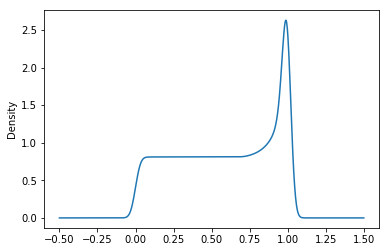

In [151]:
%matplotlib inline
south_america_plus['prob'].plot(kind='density')

In [155]:
south_america_plus = south_america_plus[south_america_plus['prob'] < 0.9]
lat_sum, lon_sum = 0, 0
num_labels = south_america_plus['label'].max() + 1
for i in range(num_labels):
    df = south_america_plus[south_america_plus['label'] == i]
    lat_sum += abs(df['lat'].max() - df['lat'].min())
    lon_sum += abs(df['lon'].max() - df['lon'].min())
lat_avg = lat_sum / num_labels
lon_avg = lon_sum / num_labels
print('Average latitudinal span:  ' + str(lat_avg))
print('Average longitudinal span: ' + str(lon_avg))

Average latitudinal span:  0.19990640482127803
Average longitudinal span: 0.13334443474646707


In [156]:
lats, lons = [], []
for i in range(num_labels):
    df = south_america_plus[south_america_plus['label'] == i]
    lats.append(abs(df['lat'].max() - df['lat'].min()))
    lons.append(abs(df['lon'].max() - df['lon'].min()))
lats = np.array(lats)
lons = np.array(lons)
print('Median latitudinal span:  ' + str(np.median(lats)))
print('Median longitudinal span: ' + str(np.median(lons)))

Median latitudinal span:  0.007248333333301105
Median longitudinal span: 0.008310000000001594


In [162]:
south_america_plus.drop(columns='prob', inplace=True)
south_america_plus.to_parquet('/home/ec2-user/Phys18Conf_1/data_files/south_america_spatial/south-america.parquet',
                              engine='fastparquet', compression=None)

In [ ]:
africa = pd.read_parquet('/home/ec2-user/Phys18Conf_1/data_files/split/africa/africa.parquet', engine='fastparquet')
africa_clusterer = hdbscan.HDBSCAN(min_cluster_size=100, min_samples=20, metric='haversine', core_dist_n_jobs=-1,
                                   algorithm='prims_balltree')
africa_clusterer.fit(np.radians(africa[['lat', 'lon']].values))
dump(africa_clusterer, '/home/ec2-user/Phys18Conf_1/data_files/pickles/africa-clustering-1.pkl')

In [4]:
elsewhere_clusterer = DBSCAN(eps=epsilon, min_samples=mspl, metric='haversine', algorithm='kd_tree', n_jobs=-1)
elsewhere_clusterer.fit(np.radians(elsewhere[['lat', 'lon']].values))
dump(elsewhere_clusterer, '/home/ec2-user/Phys18Conf_1/data_files/pickles/elsewhere-clustering-1.pkl')

In [ ]:
aussie_clusterer = DBSCAN(eps=epsilon, min_samples=mspl, metric='haversine', algorithm='kd_tree', n_jobs=-1)
aussie_clusterer.fit(np.radians(australia[['lat', 'lon']].values))
dump(aussie_clusterer, '/home/ec2-user/Phys18Conf_1/data_files/pickles/australia-clustering-1.pkl')

In [ ]:
north_america_clusterer = DBSCAN(eps=epsilon, min_samples=mspl, metric='haversine', algorithm='kd_tree', n_jobs=-1)
north_america_clusterer.fit(np.radians(north_america[['lat', 'lon']].values))
dump(north_america_clusterer, '/home/ec2-user/Phys18Conf_1/data_files/pickles/north-america-clustering-1.pkl')

In [ ]:
w_europe_clusterer = DBSCAN(eps=epsilon, min_samples=mspl, metric='haversine', algorithm='kd_tree', n_jobs=-1)
w_europe_clusterer.fit(np.radians(w_europe[['lat', 'lot']].values))
dump(w_europe_clusterer, '/home/ec2-user/Phys18Conf_1/data_files/pickles/western-europe-clustering-1.pkl')

In [ ]:
jpn_kor_clusterer = DBSCAN(eps=epsilon, min_samples=mspl, metric='haversine', algorithm='kd_tree', n_jobs=-1)
jpn_kor_clusterer.fit(np.radians(japan_korea[['lat', 'lon']].values))
dump(jpn_kor_clusterer, '/home/ec2-user/Phys18Conf_1/data_files/pickles/japan-korea-clustering-1.pkl')

In [13]:
mmnts = read_parquet('/home/ec2-user/Phys18Conf_1/data_files/sixth_trim', engine='fastparquet')
mmnts_out = mmnts.compute(scheduler='processes', optimize_graph=True)
kdims, vdims = ['Latitude', 'Longitude'], ['Value']
points = gv.Points(mmnts_out, kdims=kdims, vdims=vdims)
features = gv.Overlay([gf.ocean, gf.land, gf.coastline])
options = dict(projection=crs.InterruptedGoodeHomolosine(), width=800, height=800, size=3, color='black')
%output backend='bokeh'
(features * points).options('Points', **options)

In [8]:
#mmnts = read_parquet('/home/ec2-user/Phys18Conf_1/data_files/sixth_trim', engine='fastparquet')
#mmnts_out = mmnts.compute(scheduler='processes', optimize_graph=True)
dataset = gv.Dataset(mmnts_out, kdims=['Time', 'Value'])
#%%opts Overlay [width=700 height=700]
#%%opts Points (size=0.005 cmap='viridis') [tools=['hover'] size_index=2 color_index=2 xaxis='Longitude' yaxis='Latitude']
tiles = {'OpenMap': WMTSTileSource(url='http://c.tile.openstreetmap.org/{Z}/{X}/{Y}.png'),
         'ESRI': WMTSTileSource(url='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.jpg'),
         'Wikipedia': WMTSTileSource(url='https://maps.wikimedia.org/osm-intl/{Z}/{X}/{Y}@2x.png')}
(gv.WMTS(tiles['Wikipedia']) *\
dataset.to(gv.Points, kdims=['Longitude', 'Latitude'],
           vdims='Value', crs=crs.InterruptedGoodeHomolosine()))

KeyboardInterrupt: 

In [ ]:
%%opts Image [project=crs.InterruptedGoodeHomolosine()] (cmap='Greens')
dataset = gv.Dataset(mmnts_out.to_xarray(), kdims=kdims, vdims=vdims, crs=crs.InterruptedGoodeHomolosine())
dataset.to.image(['Latitude', 'Longitude']) * features

In [2]:
mmnts = read_parquet('/home/ec2-user/Phys18Conf_1/data_files/sixth_trim/', engine='fastparquet')
mmnts_out = mmnts.compute(scheduler='processes', optimize_graph=True)
coordinates = np.radians(mmnts_out[['Latitude', 'Longitude']].values)
spatial_clusterer = hdbscan.HDBSCAN( min_cluster_size=100, min_samples=20, metric='haversine', core_dist_n_jobs=18,
                                     memory='/home/ec2-user/Phys18Conf_1/data_files/cluster_cache' )

[########################################] | 100% Completed | 23.7s


In [ ]:
%time
spatial_clusterer.fit(coordinates)

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 11.2 µs


In [ ]:
dump(spatial_clusterer, '/home/ec2-user/Phys18Conf_1/data_files/pickles/spatial-clustering1.pkl')